### Installation
This notebook requires the MIT Uncertainty Quantification library (MUQ), which can be installed via conda from conda-forge:
```
conda install -c conda-forge muq
```
Note that to avoid build conflicts it's useful to create a new conda environment for MUQ:
```
conda create --name muq-env
conda activate muq-env
conda install -c conda-forge muq matplotlib numpy jupyterlab
```

### Useful References
- Cotter et al. (2013) "MCMC Methods for Functions: Modifying Old Algorithms to Make Them Faster"
- Hairer et al. (2014) "Spectral Gaps for a Metropolis-Hastings Algorithm in Infinite Dimensions"
- Roberts and Rosenthal (2001) "Optimal Scaling for Various Metropolis–Hastings Algorithms"

### Imports

In [1]:
import muq.Modeling as mm
import muq.Approximation as ma
import muq.SamplingAlgorithms as ms

import matplotlib.pyplot as plt
import numpy as np

# Spatial Refinement
In this notebook, we consider the problem of using MCMC to sample functions defined on the spatial domain $\Omega=[0,1]$.   We assume the functions lie in a Hilbert space $H$ and are distributed according to a zero mean Gaussian process with covariance kernel $K$, i.e., we consider $f\sim GP(0,K)$. 

To enable computation, we discretize the problem and consider the vector $f_N \in \mathbb{R}^N$, which contains the value of the function $f$ at $N$ evenly spaced points in $[0,1]$.  The following cells draws samples of $f_N$ for several values of $N$.   Notice that for large values of $N$, the samples seem to exhibit the same structure; the discrete approximation $f_N$ is a good approximation to the true function $f$.

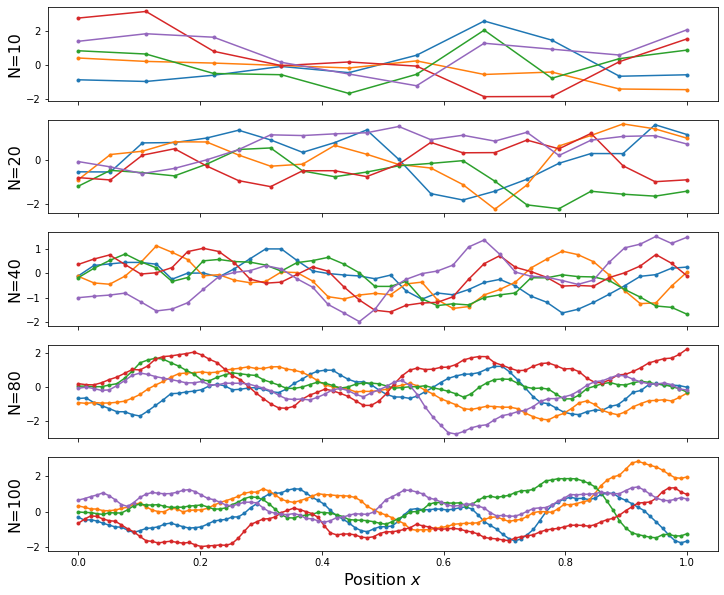

In [2]:
Ns = [10,20,40,80,100]
numSamps = 5

kern = ma.MaternKernel(1,1.0,0.1,3.0/2.0)
mean = ma.ZeroMean(1,1)

fig,axs = plt.subplots(nrows=len(Ns),sharex=True, figsize=(12,10))

for i in range(len(Ns)):
    xs = np.linspace(0,1,Ns[i]).reshape(1,-1)
    dist = ma.GaussianProcess(mean,kern).Discretize(xs)
    
    for k in range(numSamps):
        samp = dist.Sample()
        axs[i].plot(xs[0,:],samp,'.-')
    axs[i].set_ylabel("N={}".format(Ns[i]),fontsize=16)

axs[-1].set_xlabel("Position $x$",fontsize=16)
    
plt.show()

# Target Density

In [3]:
N = 100

xs = np.linspace(0,1,N).reshape(1,-1)
tgtDist = ma.GaussianProcess(mean,kern).Discretize(xs)

# Random Walk Metropolis

The random walk Metropolis algorithm defines the proposed point $f^\prime$ via

$$
f^\prime = f_k + \tau z
$$

where $z\sim N(0,\Sigma_z)$ is a zero mean Gaussian random variable with covariance $\Sigma_w$ and $\tau$ is an algorithmic parameter.    For Gaussian target distributions, optimal values of $\tau$ can be found in [Roberts and Rosenthal (2001)] for optimal scaling results used below.

In [4]:
optScale = (2.38**2)/N # <- Optimal value from Roberts and Rosenthal
propCov = optScale * tgtDist.GetCovariance()
propDist = mm.Gaussian(np.zeros(N),propCov)

In [5]:
opts = dict()
opts['NumSamples'] = 50000 # Number of MCMC steps to take
opts['BurnIn'] = 0 # Number of steps to throw away as burn in
opts['PrintLevel'] = 3 # in {0,1,2,3} Verbosity of the output

In [6]:
problem = ms.SamplingProblem(tgtDist.AsDensity())

# Construct the RWM proposal
rwmProp = ms.MHProposal(opts, problem, propDist)

# Use the proposal to construct a Metropolis-Hastings kernel
transKern = ms.MHKernel(opts,problem,rwmProp)

# Construct the MCMC sampler using this transition kernel
sampler = ms.SingleChainMCMC(opts, [transKern])

In [7]:
x0 = [tgtDist.Sample()]
samps = sampler.Run(x0)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 24%
Completed in 2.07481 seconds.


### Plot the trace of the RWM chain

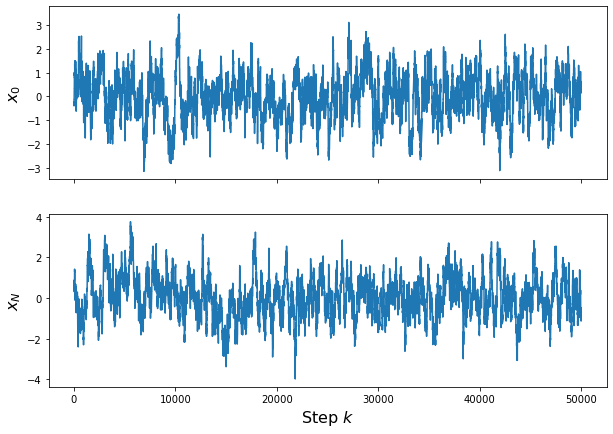

In [8]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
axs[0].plot(samps.AsMatrix()[0,:])
axs[1].plot(samps.AsMatrix()[-1,:])

axs[0].set_ylabel('$x_0$', fontsize=16)
axs[1].set_ylabel('$x_N$', fontsize=16)
axs[1].set_xlabel('Step $k$', fontsize=16)
plt.show()

### Compute the RWM Effective Sample Size (ESS)

In [9]:
ess = samps.ESS()
print('Minimum ESS = {:4.0f}'.format(np.min(ess)))

Minimum ESS =  327


# Preconditioned Crank-Nicolson (pCN)

For a zero mean target distribution, the preconditiond Crank-Nicolson proposal defines the proposed point $x^\prime$ via

$$
f^\prime = (1-\beta^2)^{1/2} f_k + \beta w,
$$

where $w\sim N(0,C)$ is a zero mean random variable with a covariance $C$ equal to the prior covariance on $f_N$.



In [10]:
opts['Beta'] = 0.75 # Crank Nicholson parameter
pcnProp = ms.CrankNicolsonProposal(opts, problem, tgtDist)

# Use the proposal to construct a Metropolis-Hastings kernel
transKern = ms.MHKernel(opts,problem,pcnProp)

# Construct the MCMC sampler using this transition kernel
sampler = ms.SingleChainMCMC(opts, [transKern])

In [11]:
x0 = [tgtDist.Sample()]
samps = sampler.Run(x0)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 100%
Completed in 2.11728 seconds.


### Plot the trace of the pCN chain

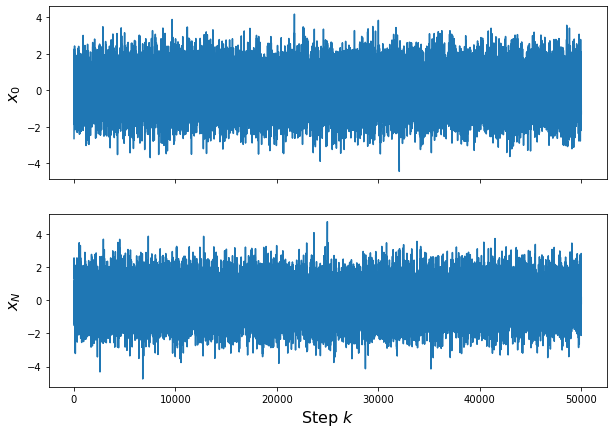

In [12]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
axs[0].plot(samps.AsMatrix()[0,:])
axs[1].plot(samps.AsMatrix()[-1,:])

axs[0].set_ylabel('$x_0$', fontsize=16)
axs[1].set_ylabel('$x_N$', fontsize=16)
axs[1].set_xlabel('Step $k$', fontsize=16)
plt.show()

### Estimate Statistical Accuracy 
Here we employ the multivariate effective sample size definition of [Vats et al., 2019](https://doi.org/10.1093/biomet/asz002) to estimate the sampling efficiency of the chain.  We also use this ESS to estimate the Monte Carlo standard error for each component of the chain.

In [13]:
batchSize = int(opts['NumSamples']/(2*N))

ess = samps.MultiBatchESS(batchSize=batchSize)
mcse = samps.MultiBatchError(batchSize=batchSize)

print('Multivariate ESS = {:4.0f}'.format(ess))
print('Min, Max MCSE = {0:4f}, {0:4f}'.format(np.min(mcse), np.max(mcse)))

Multivariate ESS = 12500
Min, Max MCSE = 0.008882, 0.008882


### Check Convergence
Running multiple independent chains from diffuse starting points allows us to assess whether the chains have converged and are producing samples of the target distribution.   The $\hat{R}$ statistic described in [Vehtari et al., 2020](http://www.stat.columbia.edu/~gelman/research/published/rhat.pdf) compares the between-chain variacne to the within-chain variance to assess convergence.  A value close to $1$ (e.g., $\hat{R}<1.01$ implies that the chains have converged.   

In the cell below, we rerun the pCN chain to obtain 4 independent chains.

In [14]:
opts['PrintLevel'] = 0 # Don't print the chain status
chains = [samps]

for i in range(1,4):
    print('Running chain {}...'.format(i), flush=True)
    sampler = ms.SingleChainMCMC(opts, [transKern])
    x0 = [tgtDist.Sample()]
    chains.append( sampler.Run(x0) )
    

Running chain 1...
Running chain 2...
Running chain 3...


Now we can compute the $\hat{R}$ statistic.  As pointed out in [Vehtari et al., 2020](http://www.stat.columbia.edu/~gelman/research/published/rhat.pdf), splitting the chain and normalizing each component can result in better estimates of convergence.   The normalization is particularly advantageous for distributions with long tails but requires a relatively expensive sorting operation.  Here we skip the normalization (since our target distribution is Gaussian anyway) by setting `Transform : False` in the dictionary of options.

In [15]:
rhat = ms.Diagnostics.Rhat(chains, {'Transform' : False})
print('Min, Max Rhat = {0:4f}, {0:4f}'.format( np.min(rhat), np.max(rhat)))

Min, Max Rhat = 1.000012, 1.000012


# Discussion

- How does the performance of the RWM proposal change with the problem dimension $N$?
- How does the performance of pCN proposal change with problem dimension?